In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Defining starting URL:
START = 'https://chicago.craigslist.org/search/apa?postal=60647&search_distance=10'

#If you get flagged for being a bot, increase this number. Can also help if the server is being slow.
# 1 is usually enough so I don't have to use async functions.
COOLDOWN = 3

In [2]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import time
import datetime
import numpy as np
import pandas as pd
import re

import requests
import json

# **Web Scraping🌎🔍**

## Defining Web Scraping Methods 🔭  🛠

1. Pull all the relevant listings from Craigslist using a GET request.



In [3]:
# Using the requests library instead of selenium because it's much much faster.

response = requests.get(START)
soup = BeautifulSoup(response.text)

listings = []
for l in soup.find_all('li')[1::]:
    url = l.a.get('href')
    title = l.find('div', 'title').text
    price = l.find('div', 'price').text
    price = re.sub(r'[^\d.]', '', str(price))
    price = int(price)

    listings.append([url, title, price])

listings = np.array(listings)

In [4]:
print("Links found:")
print(len(listings))

Links found:
337


## 2. Another GET for each URL that came up in our search

Endless parsing and data cleaning

In [5]:
def get_price(html):
    price = html.find('span', class_='price').text
    price = re.sub("\D", "", price)
    price = int(price)
    return price

def get_beds(html):
    housing = html.find('span', class_='housing')
    if housing is not None:
        beds = re.search(r'[$\d.]', housing)[0]
    else: beds = 0
    return(beds)

def get_sqft(html):
    sqft = None
    housing = html.find('span', class_='housing')
    if housing is not None:
        r = re.search("\d{2,6}ft", housing.text)
        if r:
            r = re.sub("\D", "", r.group(0))
            sqft = int(r)
        return sqft
    else: 
        return None

def get_park(html):
    #todo: this is being wonky? Usually works, often returns random crap.
    park = None
    for n in html.find_all('span', class_='valu'):
        r = re.search(".*parking",n.text)
        if r:
            park = r.group(0)
    return(park)

def get_body(html):
    body = html.find('section', id='postingbody').text
    body = re.sub("\n\nQR(.*?)\n\n", "", body)
    return(body)

def get_address(html):
    address = html.find('div', class_='mapaddress')
    if address is not None:
        location = address.text
    else: location = None
    return(location)

def get_lat_lon(html):
    try:
        lat = html.find('div', id='map').get('data-latitude')
        lon = html.find('div', id='map').get('data-longitude')
    except:
        lat=None
        lon=None

    return(lat, lon)

def get_dog(attrgroup):
    r = re.compile('.*dogs.*')
    dog = list(filter(r.match, attrgroup))
    if len(dog)>0:
        return True
    else:
        return False

def get_cat(attrgroup):
    cat = False
    for n in attrgroup:
        r = re.search(".*cats.*", n)
        if r:
            return True
            break
    return False

def get_laundry(html):
    laundry = None
    for n in html.find_all('span', class_='valu'):
        if ("w/d" in n.text) | ("laundry" in n.text):
            laundry =(n.text)
            break
    return laundry

def get_date(html):
    date = html.find("time", class_="date timeago").text.strip()
    return date

def get_thumbs(html):
    nails = html.find('div', id='thumbs')
    thumbs = []
    if nails is not None:
        thumbs = [a.get('href') for a in nails.find_all('a')]
    return thumbs


class Listing:

    def __init__(self, url):

        self.url = url
        html = BeautifulSoup(requests.get(url).content)

        # much of the key info is gettable from a json object included in the response:
        jcard = json.loads(html.find('script', id='ld_posting_data').text)
        if "numberOfBedrooms" in jcard.keys():
                self.beds = jcard["numberOfBedrooms"]
        else:
                self.beds = 0
        if "numberOfBathroomsTotal" in jcard.keys():
                self.baths = jcard["numberOfBathroomsTotal"]
        else:
                self.baths = 0

        self.lat, self.lon = (jcard['latitude'], jcard["longitude"])

        if "petsAllowed" in jcard.keys():
                self.pet = jcard["petsAllowed"]
        else:
                self.pet=None

        #There's a collection of attributes called "attrgroup" that contains a good number of features.
        #I'm just using it as a string and searching for the keywords.
        attrgroup = [attr.text.strip() for attr in html.find_all('div', class_="attr")]
        self.cat = get_cat(attrgroup)
        self.dog = get_dog(attrgroup)

        #Getting links to thumbnail pictures:
        self.thumbs = get_thumbs(html)

        self.price = get_price(html)
        self.sqft = get_sqft(html)
        self.park = get_park(html)
        self.body = get_body(html)
        self.address = get_address(html)
        self.date = get_date(html)
        self.laundry = get_laundry(html)
        
        
        uid = re.search("/(\d{10}).html", listings[:,0][5])
        self.ID = re.sub("\D", "", uid.group(0))

    def get_attributes(self):
            attrdict = {"ID":self.ID,
                "URL":self.url,
                "Price":self.price,
                "Beds":self.beds,
                "Sqft":self.sqft,
                "Park":self.park,
                "Baths":self.baths,
                "Body":self.body,
                "Addr":self.address,
                "Lat":self.lat,
                "Lon":self.lon,
                "Date":self.date,
                "Cat": self.cat,
                "Dog": self.dog,
                "WD":self.laundry}
            return attrdict

In [13]:
errors = []
def parse_listing(url):
    try:
        x = Listing(url)
        out = x.get_attributes()
        time.sleep(COOLDOWN)
        return out
    except:
        errors.append(url)

In [12]:
parse_listing(listings[5][0])

{'ID': '7729362352',
 'URL': 'https://chicago.craigslist.org/chc/apa/d/chicago-beautiful-spacious-lakeview-one/7729362352.html',
 'Price': 1895,
 'Beds': '1',
 'Sqft': 600,
 'Park': 'street parking',
 'Baths': 1,
 'Body': '\nLive in beautiful Lakeview! This building features secured entry doors, laundry on-site and is pet friendly. Walking distance to the Red line and express buses which can take you to Lincoln Park, Gold Coast, the Loop or Uptown, Edgewater and Evanston. Also near Whole Foods, Jewel and lots of restaurants and nightlife.\nThis stunning, renovated one bedroom apartment features scratch resistant light gray flooring, dark cabinets and stainless steal appliances, tons of natural light, lots of storage space. The kitchen has a stainless steel appliances, separate dining nook, the bedroom can fit at least a queen size bed plus furniture, and the bathroom is all updated with beautiful finishes.\nNo security deposit and pets are welcome! Dogs are $500, Cats are $295, 2 pet m

In [14]:
df = pd.DataFrame(listings, columns=["URL", "Header", 'Price'])
df = pd.DataFrame.from_records(df["URL"].map(parse_listing))
df

ID                                                URL  Price  \
0    7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   3500   
1    7729362352  https://peoria.craigslist.org/apa/d/chicago-mo...    685   
2    7729362352  https://springfieldil.craigslist.org/apa/d/chi...   1250   
3    7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   1450   
4    7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   1925   
..          ...                                                ...    ...   
332  7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   1445   
333  7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   1675   
334  7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   2190   
335  7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   2850   
336  7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   1450   

    Beds    Sqft                Park  Baths  \
0      2     NaN  off-street parking      2   
1      1     NaN  off-street parking      1   
2      2   972.0  off-street parking      1   
3      0   450.0      street parking      1   
4      1   600.0  off-street parking      1   
..   ...     ...                 ...    ...   
332    0     NaN          no parking      1   
333    0     NaN          no parking      1   
334    3  1250.0          no parking      1   
335    3  1250.0                None      2   
336    0     NaN      street parking      1   

                                                  Body  \
0    \nPROPERTY INFO\nID: 253472419Rent: $3,500 / M...   
1    \nWe have a spacious one bedroom available for...   
2    \n2 Bedroom, 1 bathroom, 3 room apartment, ~97...   
3    \nLive in this East Lakeview 2 ROOM studio apa...   
4    \nIn the heart of Lakeview East sits this elev...   
..                                                 ...   
332  \nWelcome home! Enjoy stainless steel applianc...   
333  \nWelcome to 244 E Pearson. !!!This building h...   
334  \nPROPERTY INFO\nID: 289669673Rent: $2,190 / M...   
335  \nThe summary::\n\n- 3 bedrooms \n- 2 baths\n-...   
336  \nPROPERTY INFO\nID: 34416689Rent: $1,450 / Mo...   

                                    Addr        Lat         Lon  \
0                                   None  41.939900  -87.652800   
1                                   None  41.920900  -87.704300   
2                   1432 W Glenlake Ave,  41.992931  -87.666372   
3                            725 W Barry  41.937980  -87.646972   
4                       445 W Wellington  41.936687  -87.640732   
..                                   ...        ...         ...   
332                                 None  41.897100  -87.622300   
333                                 None  41.897100  -87.622300   
334           W Armitage near N Rockwell  41.917639  -87.693343   
335           1215 N Damen near Division  41.903717  -87.677308   
336  3808 North Sheffield Ave near Grace  41.951462  -87.654659   

                 Date    Cat                  Dog               WD  
0    2024-03-21 10:23   True                False      w/d in unit  
1    2024-03-21 10:08   True  dogs are OK - wooof  laundry on site  
2    2024-03-21 10:03   True  dogs are OK - wooof      w/d in unit  
3    2024-03-21 10:16   True  dogs are OK - wooof  laundry on site  
4    2024-03-21 10:11   True  dogs are OK - wooof  laundry in bldg  
..                ...    ...                  ...              ...  
332  2024-03-18 16:29   True                False  laundry on site  
333  2024-03-18 16:29   True                False  laundry on site  
334  2024-03-18 16:08   True  dogs are OK - wooof      w/d in unit  
335  2024-03-18 16:04  False                False      w/d in unit  
336  2024-03-18 15:59   True                False  laundry in bldg  

[337 rows x 15 columns]

In [15]:
version = datetime.date.today().strftime("%y%m%d")
df.to_csv('~/'+version+'cl-scraped.csv')

# Analysis

In [16]:
df = pd.read_csv("~/240321cl-scraped.csv")
df.head()

Unnamed: 0          ID                                                URL  \
0           0  7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   
1           1  7729362352  https://peoria.craigslist.org/apa/d/chicago-mo...   
2           2  7729362352  https://springfieldil.craigslist.org/apa/d/chi...   
3           3  7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   
4           4  7729362352  https://chicago.craigslist.org/chc/apa/d/chica...   

   Price  Beds   Sqft                Park  Baths  \
0   3500     2    NaN  off-street parking      2   
1    685     1    NaN  off-street parking      1   
2   1250     2  972.0  off-street parking      1   
3   1450     0  450.0      street parking      1   
4   1925     1  600.0  off-street parking      1   

                                                Body                  Addr  \
0  \nPROPERTY INFO\nID: 253472419Rent: $3,500 / M...                   NaN   
1  \nWe have a spacious one bedroom available for...                   NaN   
2  \n2 Bedroom, 1 bathroom, 3 room apartment, ~97...  1432 W Glenlake Ave,   
3  \nLive in this East Lakeview 2 ROOM studio apa...           725 W Barry   
4  \nIn the heart of Lakeview East sits this elev...      445 W Wellington   

         Lat        Lon              Date   Cat                  Dog  \
0  41.939900 -87.652800  2024-03-21 10:23  True                False   
1  41.920900 -87.704300  2024-03-21 10:08  True  dogs are OK - wooof   
2  41.992931 -87.666372  2024-03-21 10:03  True  dogs are OK - wooof   
3  41.937980 -87.646972  2024-03-21 10:16  True  dogs are OK - wooof   
4  41.936687 -87.640732  2024-03-21 10:11  True  dogs are OK - wooof   

                WD  
0      w/d in unit  
1  laundry on site  
2      w/d in unit  
3  laundry on site  
4  laundry in bldg

In [17]:
df["WD"].unique()

array(['w/d in unit', 'laundry on site', 'laundry in bldg',
       'no laundry on site', 'w/d hookups'], dtype=object)

In [23]:
df["Park"].replace(["off-street parking", "garage"], True, inplace=True)
df["Park"].replace(["street parking", 'no', None, "no parking"], False, inplace=True)

In [24]:
df["Park"].unique()

array([ True, False])

In [100]:
df["WD"].replace(['laundry in bldg', 'laundry on site'], 0.5, inplace=True)
df["WD"].fillna(0, inplace=True)

In [26]:
df.describe()

Unnamed: 0            ID        Price        Beds          Sqft  \
count  337.000000  3.370000e+02   337.000000  337.000000    100.000000   
mean   168.000000  7.729362e+09  2065.697329    1.456973   1243.340000   
std     97.427751  0.000000e+00  1066.483302    1.014223   1835.127261   
min      0.000000  7.729362e+09   525.000000    0.000000    135.000000   
25%     84.000000  7.729362e+09  1356.000000    1.000000    700.000000   
50%    168.000000  7.729362e+09  1800.000000    1.000000    925.000000   
75%    252.000000  7.729362e+09  2525.000000    2.000000   1220.000000   
max    336.000000  7.729362e+09  9500.000000    5.000000  15203.000000   

            Baths         Lat         Lon  
count  337.000000  337.000000  337.000000  
mean     1.234421   41.930829  -87.674744  
std      0.470817    0.049015    0.046756  
min      1.000000   41.778100  -87.873400  
25%      1.000000   41.897100  -87.696855  
50%      1.000000   41.927132  -87.663743  
75%      1.000000   41.960731  -87.644271  
max      3.000000   42.057029  -87.600600

<AxesSubplot:xlabel='Sqft', ylabel='Price'>

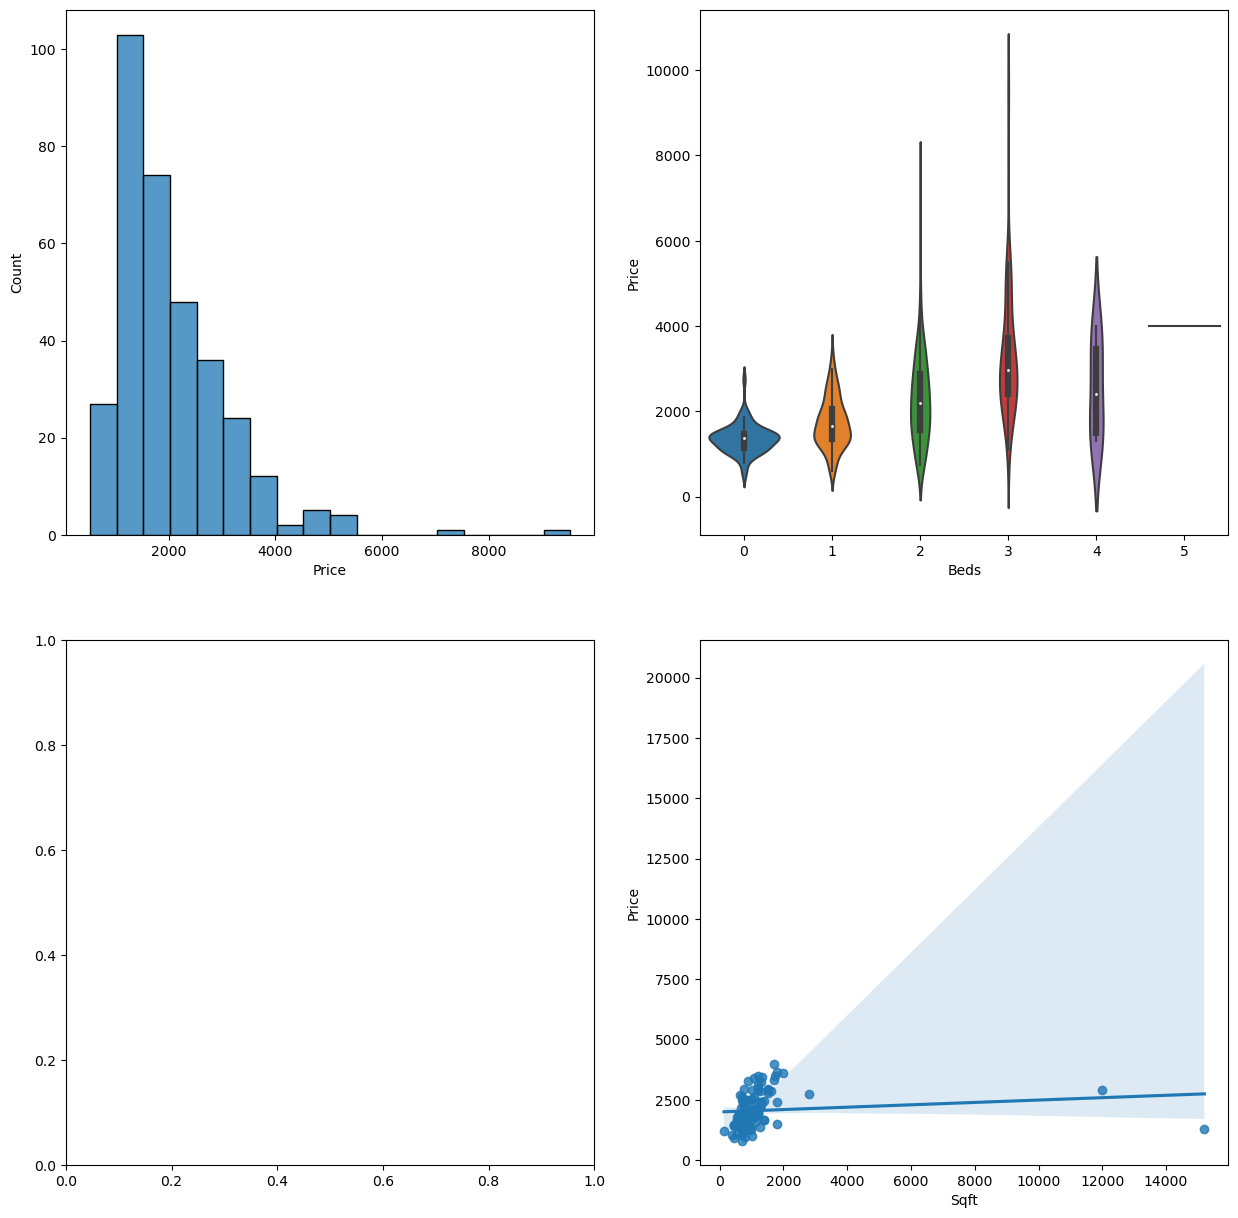

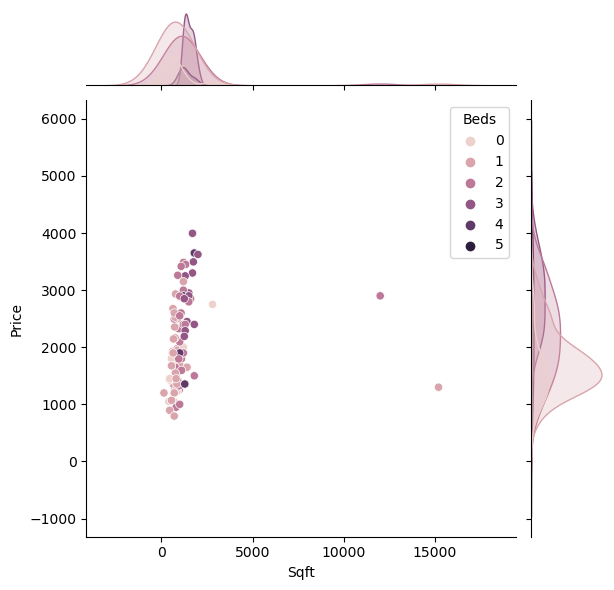

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2 , figsize=(15, 15))
sns.histplot(ax=axes[0,0], data=df['Price'], binwidth=500)
sns.violinplot(ax=axes[0,1], x=df["Beds"], y=df["Price"])
sns.jointplot(ax=axes[1,0], x=df[df['Sqft']>0]['Sqft'], y=df[df['Sqft']>0]['Price'], hue=df['Beds'])
sns.regplot(ax=axes[1,1], x=df[df['Sqft']>0]['Sqft'], y=df[df['Sqft']>0]['Price'])

In [183]:
y=df["Price"]
x=df[["Park", "Beds", "Baths", "Lat", "Lon", "Dog"]]

In [184]:
from sklearn.model_selection import train_test_split

In [239]:
xtrain, xtest, ytrain, ytest, = train_test_split(x, y, test_size=0.2)

In [240]:
xtrain

Park  Beds  Baths        Lat        Lon    Dog
244  False     2      1  41.918485 -87.719513   True
100  False     0      1  41.954300 -87.657500  False
288  False     1      1  41.932582 -87.659454  False
37   False     1      1  41.879300 -87.843300   True
290  False     2      2  41.922900 -87.648300  False
..     ...   ...    ...        ...        ...    ...
227   True     2      2  41.967432 -87.657855   True
102  False     1      1  41.990900 -87.662900  False
155  False     0      1  41.940532 -87.676055  False
242  False     1      1  41.937744 -87.671689   True
26   False     1      1  41.892300 -87.637300   True

[238 rows x 6 columns]

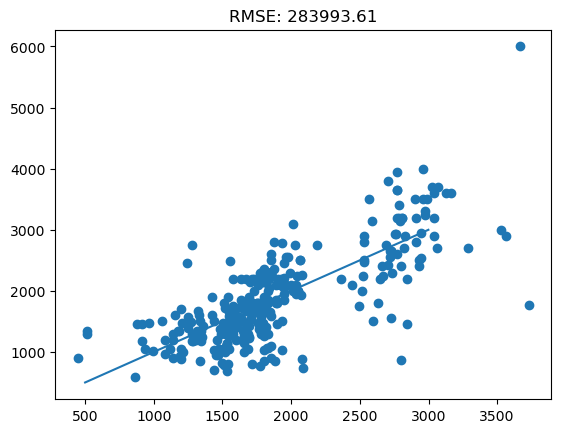

In [242]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
linreg = linear_model.LinearRegression()
linreg.fit(xtrain, ytrain)
ypred = linreg.predict(x)
fig, ax = plt.subplots()
plt.title("RMSE: "+str(round(rmse, 2)))
ax.scatter(ypred, y)
ax.plot(range(500,3000), range(500,3000), "-")
rmse = mean_squared_error(y, ypred)

In [198]:
linreg.predict([[0,3,2,41.927315, -87.718324, 1]])

C:\Users\gbwie\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([2722.12310149])

In [200]:
from sentence_transformers import SentenceTransformer
mp = SentenceTransformer("all-mpnet-base-v2")

In [219]:
encoded = df["Body"].apply(lambda x: mp.encode(x))

In [227]:
list(encoded)

[array([-1.49083780e-02,  6.85122311e-02,  2.02806797e-02,  2.54202820e-02,
        -2.83265766e-02,  2.62485277e-02, -7.60334497e-03,  2.37802602e-02,
        -2.30270009e-02,  4.85894531e-02, -7.28504360e-02,  3.80981620e-03,
         1.09198466e-02,  5.70284836e-02, -9.48375277e-03,  5.42433634e-02,
        -2.27406272e-03,  2.13614926e-02, -1.53309805e-02,  1.14919108e-04,
        -5.74678816e-02,  7.71924108e-02, -3.69534530e-02, -1.00782607e-02,
         8.24667979e-03,  2.26713009e-02, -5.50197251e-02,  1.78637765e-02,
         1.59242693e-02, -4.21551950e-02, -3.52653712e-02,  4.46914658e-02,
        -1.47113632e-02,  1.64423399e-02,  2.09087352e-06, -1.51270558e-03,
        -3.89353186e-02,  2.51596719e-02, -4.40982915e-02, -5.00457585e-02,
         3.88935842e-02, -3.48137543e-02, -2.89074779e-02, -1.95004176e-02,
         3.85549432e-03, -9.28369313e-02,  1.49597740e-02,  3.54008861e-02,
        -4.13902849e-02,  8.89597740e-03,  1.05368113e-02, -1.09426090e-02,
         1.7

In [228]:
nlpreg = linear_model.LinearRegression()
nlpreg.fit(list(encoded), list(y))

LinearRegression()

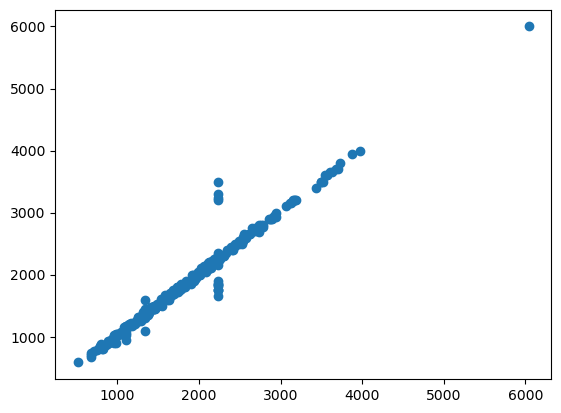

In [229]:
nlppred = nlpreg.predict(list(encoded))
plt.scatter(nlppred, y)

In [237]:
df["Body"][5]

'\n\nQR Code Link to This Post\n\n\nSpectacular custom renovation. Totally redone. Used extremely gently used as an in-town home. One bedroom and 1.5 baths. Open custom top-of-the-line kitchen with fabulous finishes including granite with circular dining peninsula, top-of-the-line stainless steel appliances and washer/dryer. Stone powder room with beautiful top-of-the-line finishes. Master suite with outfitted walk-in closet and out-of-this-world full stone bath with oversized shower and top-of-the-line finishes. Custom designed window seats and Roman shades throughout. Tremendous views from the 51st floor looking down Lake Shore Drive. Plus east and west vistas. Barely lived-in home. Just bring you tooth brush. Full amenity building. **\n'

In [244]:
nlpreg.predict(mp.encode(df["Body"][5]).reshape(1,-1))

array([1541.], dtype=float32)

In [246]:
df["Body"][5]

'\n\nQR Code Link to This Post\n\n\nSpectacular custom renovation. Totally redone. Used extremely gently used as an in-town home. One bedroom and 1.5 baths. Open custom top-of-the-line kitchen with fabulous finishes including granite with circular dining peninsula, top-of-the-line stainless steel appliances and washer/dryer. Stone powder room with beautiful top-of-the-line finishes. Master suite with outfitted walk-in closet and out-of-this-world full stone bath with oversized shower and top-of-the-line finishes. Custom designed window seats and Roman shades throughout. Tremendous views from the 51st floor looking down Lake Shore Drive. Plus east and west vistas. Barely lived-in home. Just bring you tooth brush. Full amenity building. **\n'

In [250]:
desc = """
\n\nQR Code Link to This Post\n\n\nHuge, one-of-a-kind three-bed unit in owner-occupied Logan Square home. 
This unit is a truly unique three-bedroom duplex-down. The main floor boasts the original maple flooring, and east-facing chicago windows for tons of natural light.
Vintage charm continues through the ample dining room and fully modern kitchen with brand-new stainless Samsung appliances.
The 1000-square-foot downstairs has brand-new flooring throughout. The downstairs bedroom is totally silent day or night and features an en-suite bath with whirlpool tub, stand-up shower and washer/dryer.
The third bedroom, at the back of the downstairs is the smallest of the three and would be well suited to a young child or as a work space.
Owner pays sewer and trash. Gigabit internet included. Dogs welcome. **\n"""

nlpreg.predict(mp.encode(desc).reshape(1,-1))

array([-730406.], dtype=float32)